# **Titanic with a Keras Neural Network tutorial ! 🧠**

### Hi Kagglers ! 👋👋👋

### Welcome on this tutorial ! This is aimed for beginners but whatever your level you could read it, and if you find a way to improve it i encourage you to fork this notebook and contribute by adding a better solution :D

### Let's go !

![](https://i.ytimg.com/vi/yuMNWt6S0ZA/maxresdefault.jpg)

### In this notebook, we are going to predict wether a passenger of the famous boat will survive or not ! By doing this, we will go through several topics and fundamental techniques of machine learning. Here is a list of these techniques and some additional resources that you can consult to find out more: 

- [EDA | Data exploration](https://medium.com/python-pandemonium/introduction-to-exploratory-data-analysis-in-python-8b6bcb55c190)
- [Features engineering](https://adataanalyst.com/machine-learning/comprehensive-guide-feature-engineering/)
- [Evaluating a model over one training | metrics](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)
- [Evaluating a model over several trainings | k-fold cross validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
- [Neural network with keras](https://elitedatascience.com/keras-tutorial-deep-learning-in-python)

## **Imports and useful functions**

In [1]:
import pandas as pd
import matplotlib
import pydot
import re

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import sklearn
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

Using TensorFlow backend.


In [2]:
#path of datasets
path_train = '../input/train.csv'
path_test = '../input/test.csv'

def display_confusion_matrix(sample_test, prediction, score=None):
    cm = metrics.confusion_matrix(sample_test, prediction)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        all_sample_title = 'Accuracy Score: {0}'.format(score)
        plt.title(all_sample_title, size = 15)
    print(metrics.classification_report(sample_test, prediction))
    
def visualize_tree(tree, feature_names):
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)
    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

## **1. Data exploration**

In [3]:
#create dataframe for training dataset and print ten first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Compute some basical statistics on the dataset
train_df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
draw_missing_data_table(train_df_raw)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


### There is 77% of missing data in the cabin column, it's way too much for this column to be exploitable, so we'll remove it from the dataframe. For the age, we will either interpolate missing values or we will fill it with the median. There is only two missing values for the embarked column, let's replace them by the most recurrent value of Embarqued variable :

In [7]:
train_df_raw['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

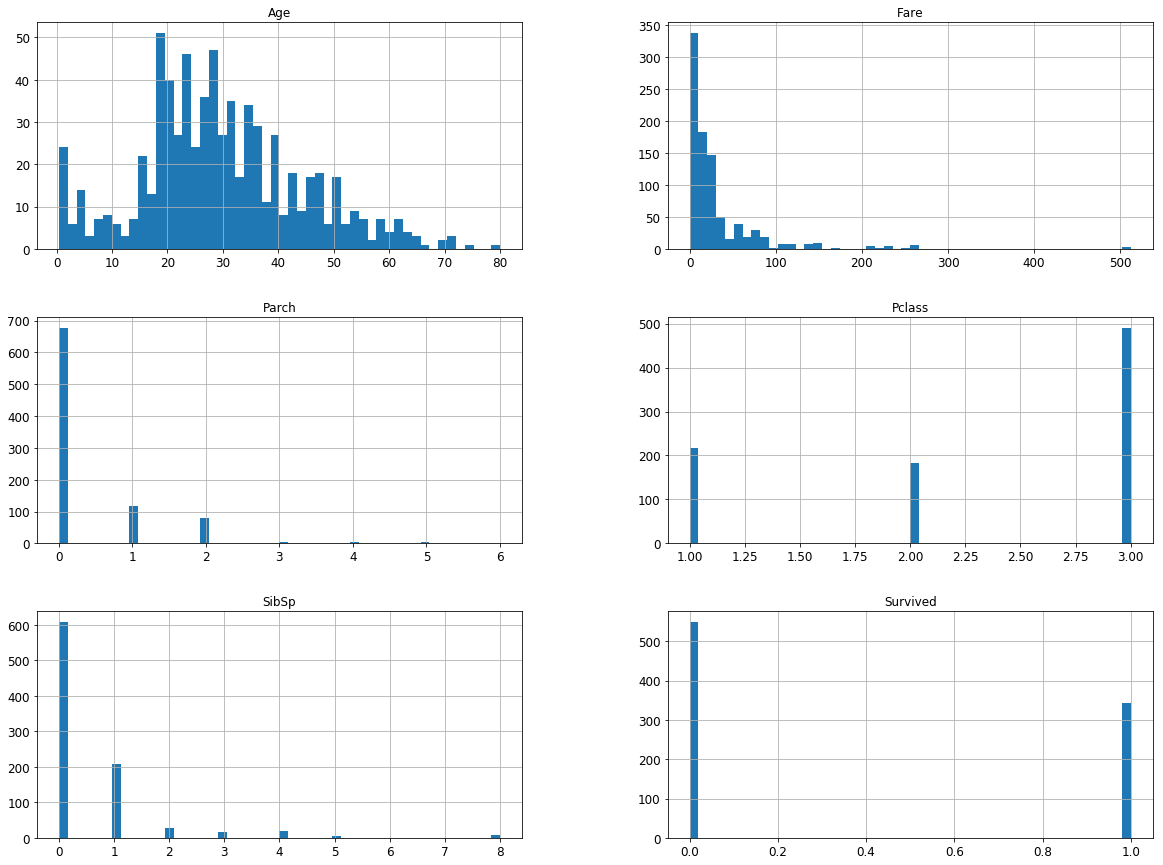

In [8]:
# Let's plot some histograms to have a previzualisation of some of the data ...
train_df_raw.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

### With this first exploration, we can see that :

* Only aproximately 35% of passengers survived ...
* More than the half of passengers are in the lowest class (pclass = 3)
* Most of the fare tickets are below 50
* Majority of passengers are alone (sibsp and parch)

## **2. Features engineering**

### My advice is to group all the transformations to be done on the dataset in a single function. This way, you can apply the same changes to the training dataset and the test dataset easily. Moreover, if you want to add a modification, you'll have to do it only in the function!

In [9]:
def preprocess_data(df):
    
    processed_df = df
    
    # Drop useless columns
    processed_df = processed_df.drop(['PassengerId'], 1)
    
    # Deal with missing values
    processed_df['Embarked'].fillna('S', inplace=True)
    processed_df['Age'].fillna(processed_df['Age'].mean(), inplace=True)
    processed_df['Age'] = processed_df['Age'].astype(int)
    processed_df['Fare'] = processed_df['Fare'].interpolate()
    processed_df['Cabin'].fillna('U', inplace=True)
    
    # feature engineering on columns
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in train_df_raw['Name']), index=train_df_raw.index)
    processed_df['Title'] = processed_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    processed_df['Title'] = processed_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['Title'] = processed_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    
    processed_df['Sex'] = processed_df['Sex'].map({'male': 0, 'female': 1})
    processed_df['Embarked'] = processed_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    processed_df['Familly_size'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['IsAlone'] = np.where(processed_df['Familly_size']!=1, 0, 1)
    
    #Creation of a deck column corresponding to the letter contained in the cabin value
    processed_df['Cabin'] = processed_df['Cabin'].str[:1]
    processed_df['Cabin'] = processed_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in processed_df['Cabin']))})
    
    processed_df = processed_df.drop(['Name', 'Ticket'], 1)    
    
    return processed_df

## **3. Try several models on train dataset**

In [10]:
# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
train_df = train_df_raw.copy()
X = train_df.drop(['Survived'], 1)
Y = train_df['Survived']

X = preprocess_data(X)
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
    
# Split dataset for prediction
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Familly_size,IsAlone
331,-1.566107,-0.737695,1.188306,-0.474545,-0.473674,-0.074583,-1.180472,-0.568837,-0.707550,-0.560975,0.811922
733,-0.369365,-0.737695,-0.503160,-0.474545,-0.473674,-0.386671,0.294704,-0.568837,-0.707550,-0.560975,0.811922
382,0.827377,-0.737695,0.188804,-0.474545,-0.473674,-0.488854,0.294704,-0.568837,-0.707550,-0.560975,0.811922
704,0.827377,-0.737695,-0.272505,0.432793,-0.473674,-0.490280,0.294704,-0.568837,-0.707550,0.059160,-1.231645
813,0.827377,1.355574,-1.810201,3.154809,2.008933,-0.018709,0.294704,-0.568837,0.263832,3.159833,-1.231645


### **1.1 Logistic regression**

### Logistic regression is the "hello world" of machine learning algorithms. It is very simple to understand how it works, [here](https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102) is a good article which cover theory of this algorithm.

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       105
           1       0.74      0.74      0.74        74

   micro avg       0.79      0.79      0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



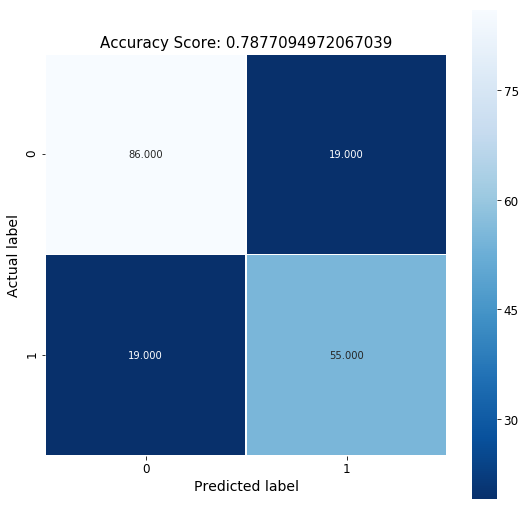

In [11]:
# Create and train model on train data sample
logisticRegr = LogisticRegression(random_state=42)
logisticRegr.fit(X_train, Y_train)

# Predict for test data sample
logistic_prediction = logisticRegr.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, logistic_prediction)
display_confusion_matrix(Y_test, logistic_prediction, score=score)

### **1.2 Decision tree**

### Decision tree is a quite intuitive model, easy to vizualize and interpret. Here, we are even going to display our tree to improve our understanding on how the algorithm manage to classify our samples:

### To find out more about decision trees: [DT](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248)


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

   micro avg       0.81      0.81      0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



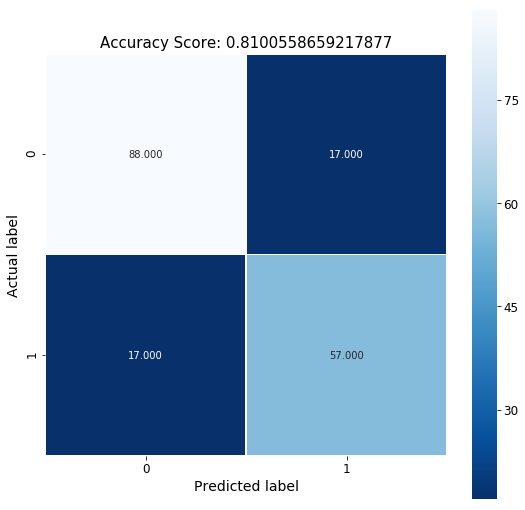

In [12]:
# Create and train model on train data sample
dt = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=20, random_state=42)
dt.fit(X_train, Y_train)

# Predict for test data sample
dt_prediction = dt.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, dt_prediction)
display_confusion_matrix(Y_test, dt_prediction, score=score)


In [13]:
visualize_tree(dt, X_test.columns)
! dot -Tpng dt.dot > dt.png

![title](dt.png)

### **1.3 Random forest**

### Random forest is a robust & practical algorithm based on decision trees. It outperforms almost always the two previous algorithm we saw. If you want to find out more about this model, [here](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d) is a good start.

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

   micro avg       0.82      0.82      0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



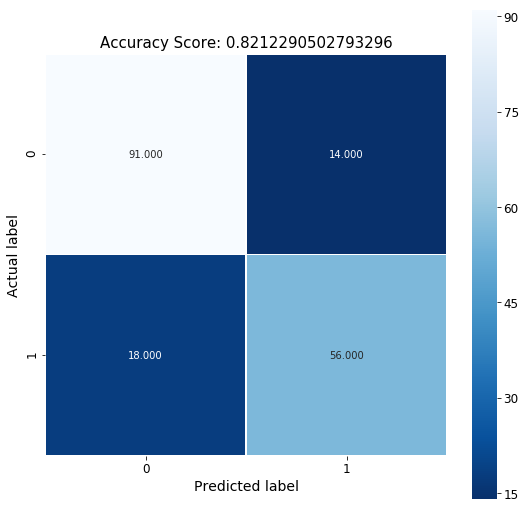

In [14]:
# Create and train model on train data sample
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Predict for test data sample
rf_prediction = rf.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, rf_prediction)
display_confusion_matrix(Y_test, rf_prediction, score=score)

### **1.4 Artificial neural network**

### To build our neural network, we are going to use Keras. Keras is a high level API for tensorflow, which is a tensor-manipulation framework made by google. It allows to build neural networks by assembling blocks (which are the layers of our neural network). For more details, [here](https://elitedatascience.com/keras-tutorial-deep-learning-in-python) is a great keras tutorial. 

In [15]:
def build_ann(optimizer='adam'):
    # Initializing our ANN
    ann = Sequential()
    # Adding the input layer and the first hidden layer of our ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_normal', activation='relu', input_shape = (11,)))
    ann.add(Dropout(p=0.5)) # Dropout will disable some neurons (here 50% of all neurons) to avoid overfitting
    # Add another layer, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_normal', activation='relu'))
    ann.add(Dropout(p=0.5))
    ann.add(Dense(units=128, kernel_initializer='glorot_normal', activation='relu'))
    ann.add(Dropout(p=0.5))
    ann.add(Dense(units=164, kernel_initializer='glorot_normal', activation='relu'))
    ann.add(Dropout(p=0.5))
    ann.add(Dense(units=16, kernel_initializer='glorot_normal', activation='relu'))
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_normal', activation='sigmoid'))
    
    # Compilling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [16]:
ann = build_ann()
# Training the ANN
ann.fit(X_train, Y_train, batch_size=10, epochs=100)

Epoch 1/100
712/712 [==============================] - 1s 2ms/step - loss: 0.6852 - acc: 0.5885
Epoch 2/100
712/712 [==============================] - 0s 281us/step - loss: 0.6359 - acc: 0.6629
Epoch 3/100
712/712 [==============================] - 0s 312us/step - loss: 0.6151 - acc: 0.6882
Epoch 4/100
712/712 [==============================] - 0s 312us/step - loss: 0.5787 - acc: 0.7289
Epoch 5/100
712/712 [==============================] - 0s 323us/step - loss: 0.5714 - acc: 0.7388
Epoch 6/100
712/712 [==============================] - 0s 333us/step - loss: 0.5548 - acc: 0.7458
Epoch 7/100
712/712 [==============================] - 0s 290us/step - loss: 0.5222 - acc: 0.7795
Epoch 8/100
712/712 [==============================] - 0s 290us/step - loss: 0.4977 - acc: 0.7865
Epoch 9/100
712/712 [==============================] - 0s 343us/step - loss: 0.5147 - acc: 0.7893
Epoch 10/100
712/712 [==============================] - 0s 316us/step - loss: 0.4988 - acc: 0.7949
Epoch 11/100
712/712 

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

   micro avg       0.80      0.80      0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



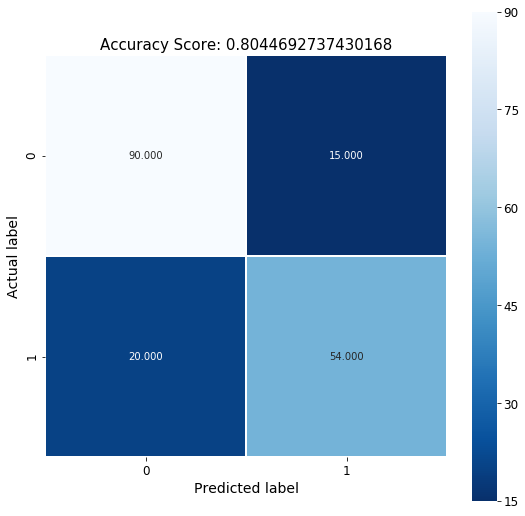

In [17]:
# Predicting the Test set results
ann_prediction = ann.predict(X_test)
ann_prediction = (ann_prediction > 0.5) # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, ann_prediction)
display_confusion_matrix(Y_test, ann_prediction, score=score)

## **4. Finding the best model using k-folds cross validation**

### The precision we calculated above does not mean anything. In fact, if we execute each cell again, we could have sightly different accuracy, because we trained again our models ! We need to verify which model has the best accuracy over several training steps ! We can do it using cross validation method, which consists of dividing out training set in k parts (folds) and evaluating k times using successively each part as the test set and the 9 other parts as the training set. Therefore, we can compute a mean error over the 10 trainings of our model:

![](https://www.researchgate.net/profile/Kiret_Dhindsa/publication/323969239/figure/fig10/AS:607404244873216@1521827865007/The-K-fold-cross-validation-scheme-133-Each-of-the-K-partitions-is-used-as-a-test.png)

### Let's check which one of our previously implemented model is the best one with this method. We will not only compute the mean but also the variance, because a good model needs to have the lowest possible variance in addition to have a low bias:

![](https://www.machinelearningtutorial.net/wp-content/uploads/2017/01/bias-variance-tradeoff.svg)

In [18]:
accuracies_logreg = cross_val_score(estimator=logisticRegr, X=X_train, y=Y_train, cv=10, n_jobs=-1)
accuracies_tree = cross_val_score(estimator=dt, X=X_train, y=Y_train, cv=10, n_jobs=-1)
accuracies_rf = cross_val_score(estimator=rf, X=X_train, y=Y_train, cv=10, n_jobs=-1)
accuracies_ann = cross_val_score(estimator=KerasClassifier(build_fn=build_ann, batch_size=10, epochs=100, verbose=0),
                                 X=X_train, y=Y_train, cv=10, n_jobs=-1)

In [19]:
accuracies = {'lg': accuracies_logreg, 'dt': accuracies_tree, 'rf': accuracies_rf, 'ann': accuracies_ann}
mean = {model: acc.mean() for model, acc in accuracies.items()}
variance = {model: acc.std() for model, acc in accuracies.items()}
print('Mean accuracy:', mean, '\nVariance:', variance)

Mean accuracy: {'lg': 0.8160485133020344, 'dt': 0.8147389894925106, 'rf': 0.803608316566063, 'ann': 0.8272300419276682} 
Variance: {'lg': 0.05686962089966161, 'dt': 0.051218460274826204, 'rf': 0.05877331020535597, 'ann': 0.05162398106897395}


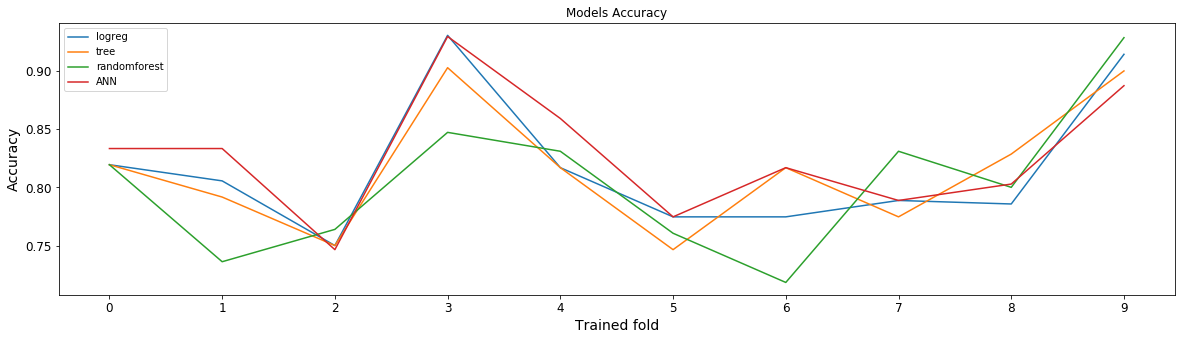

In [20]:
plt.figure(figsize=(20,5))
plt.plot(accuracies['lg'])
plt.plot(accuracies['dt'])
plt.plot(accuracies['rf'])
plt.plot(accuracies['ann'])
plt.title('Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trained fold')
plt.xticks([k for k in range(10)])
plt.legend(['logreg', 'tree', 'randomforest', 'ANN'], loc='upper left')
plt.show()

### Our artificial neural network seems to be the best model : it has the best accuracy and the lowest variance ! Let's make a prediction on test dataset now and submit it on kaggle !

## 5. Apply the best model on test dataset and submit on kaggle 

In [21]:
test_df_raw = pd.read_csv(path_test)
test = test_df_raw.copy()
test = preprocess_data(test)
test = pd.DataFrame(sc.fit_transform(test.values), index=test.index, columns=test.columns)

In [22]:
# Create and train model on train data sample
model_test = build_ann()
model_test.fit(X, Y, batch_size=10, epochs=100)

# Predict for test data sample
prediction = model_test.predict(test)
prediction = (prediction > 0.5)*1

result_df = test_df_raw.copy()
result_df['Survived'] = prediction
result_df.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)

Epoch 1/100
891/891 [==============================] - 1s 892us/step - loss: 0.6798 - acc: 0.5915
Epoch 2/100
891/891 [==============================] - 0s 206us/step - loss: 0.6231 - acc: 0.6487
Epoch 3/100
891/891 [==============================] - 0s 215us/step - loss: 0.5969 - acc: 0.6902
Epoch 4/100
891/891 [==============================] - 0s 211us/step - loss: 0.5817 - acc: 0.7262
Epoch 5/100
891/891 [==============================] - 0s 209us/step - loss: 0.5509 - acc: 0.7643
Epoch 6/100
891/891 [==============================] - 0s 201us/step - loss: 0.5318 - acc: 0.7632
Epoch 7/100
891/891 [==============================] - 0s 200us/step - loss: 0.5052 - acc: 0.7800
Epoch 8/100
891/891 [==============================] - 0s 205us/step - loss: 0.4708 - acc: 0.7912
Epoch 9/100
891/891 [==============================] - 0s 208us/step - loss: 0.5181 - acc: 0.7856
Epoch 10/100
891/891 [==============================] - 0s 209us/step - loss: 0.4764 - acc: 0.7890
Epoch 11/100
891/89

In [23]:
result_df[['PassengerId', 'Survived']].head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
